# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [3]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

# magic word for producing visualizations in notebook
%matplotlib inline

# sklearn
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix,precision_recall_fscore_support
from sklearn.utils.multiclass import unique_labels

#
from imblearn.over_sampling import RandomOverSampler

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [4]:
# load in the data
start_time = time.time()
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
print("--- %s seconds ---" % (time.time() - start_time))

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


--- 289.14540123939514 seconds ---


In [5]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [6]:
azdias.shape

(891221, 366)

In [7]:
# Check datasize memory size
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(93), object(6)
memory usage: 2.4+ GB


In [8]:
# Check at the type of all columns
azdias.dtypes.value_counts()

float64    267
int64       93
object       6
dtype: int64

In [9]:
# Luckily most of the columns are float64 and int64, which are okay format for ML modeling.
# We'll need to transform the 6 object columns if we want to use it though.
azdias.select_dtypes('object').head()

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ
0,NaN,NaN,NaN,NaN,NaN,NaN
1,8A,8,51,NaN,1992-02-10 00:00:00,W
2,4C,4,24,D19_UNBEKANNT,1992-02-12 00:00:00,W
3,2A,2,12,D19_UNBEKANNT,1997-04-21 00:00:00,W
4,6B,6,43,D19_SCHUHE,1992-02-12 00:00:00,W


## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

### Step 1.1: Assess Missing Data
With help of the DIAS Attributes, we will look for the meaning of attributes, and see what indicates an unknown value. We'll treat unknown value equivalently to missing value. In fact, we'll replace every value that is found to be unknown (based on its value) with a NaN.

Added a posteriori: some fields contain 'X' or 'XX' for unknown values, that also have to be replaced with nan.

In [14]:
# Attributes from term 2
attributes = pd.read_excel('DIAS Attributes - Values 2017.xlsx')
print(attributes.shape)
attributes.head(6)

(2258, 5)


,Unnamed: 0,Attribute,Description,Value,Meaning
0,NaN,AGER_TYP,best-ager typology,-1,unknown
1,NaN,NaN,NaN,0,no classification possible
2,NaN,NaN,NaN,1,passive elderly
3,NaN,NaN,NaN,2,cultural elderly
4,NaN,NaN,NaN,3,experience-driven elderly
5,NaN,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown


In [15]:
# Remove useless column, and apply fillforward on Attribute column
attributes.drop(columns=['Unnamed: 0'], inplace=True)
attributes['Attribute'] = attributes['Attribute'].ffill()
attributes.head(6)

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,NaN,0,no classification possible
2,AGER_TYP,NaN,1,passive elderly
3,AGER_TYP,NaN,2,cultural elderly
4,AGER_TYP,NaN,3,experience-driven elderly
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown


In [16]:
# Below a list of occurence of every "Meaning" which seems to indicates unknown data (unknown, or without known, etc).
attributes['Meaning'].where(attributes['Meaning'].str.contains('known')).value_counts()

unknown                                                           232
no transaction known                                               34
no transactions known                                              22
mixed building without actually known household or comapny          1
mixed building without actually known household                     1
mixed building without actually known company                       1
unknown / no main age detectable                                    1
residental building buildings without actually known household      1
company building w/o known company                                  1
Name: Meaning, dtype: int64

In [17]:
# Let's save meanings that indicate unknown values 
# The transaction ones, as well as building ones seem to contain some info so we will keep it.)
unknown_names = attributes['Meaning'].where(attributes['Meaning'].str.contains('unknown')).value_counts().index
list(unknown_names)

['unknown', 'unknown / no main age detectable']

In [18]:
# We now have the list of all unknown values per Attribute.
attributes_missing = attributes[attributes['Meaning'].isin(unknown_names)]
attributes_missing.head()

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
11,ALTER_HH,main age within the household,0,unknown / no main age detectable
33,ANREDE_KZ,gender,"-1, 0",unknown
40,BALLRAUM,distance to next urban centre,-1,unknown


In [19]:
# let's replace all unknown values with NaN
for row in attributes_missing.iterrows():
    missing_values = row[1]['Value']
    attribute = row[1]['Attribute']
    # Some attributes of DIAS Attributes do not exist in the AZDIAS dataset ...
    if attribute not in azdias.columns:
        print(attribute+' is surpisingly not found in azdias.')
        continue        
    
    print('Treating '+attribute)
    
    # different treatement if missing_values is a string or a int
    if isinstance(missing_values,int): 
        azdias[attribute].replace(missing_values, np.nan, inplace=True)
    elif isinstance(missing_values,str):
        eval("azdias[attribute].replace(["+missing_values+"], np.nan, inplace=True)")

Treating AGER_TYP
Treating ALTERSKATEGORIE_GROB
Treating ALTER_HH
Treating ANREDE_KZ
Treating BALLRAUM
BIP_FLAG is surpisingly not found in azdias.
Treating CAMEO_DEUG_2015
CAMEO_DEUINTL_2015 is surpisingly not found in azdias.
Treating CJT_GESAMTTYP
D19_KK_KUNDENTYP is surpisingly not found in azdias.
Treating EWDICHTE
Treating FINANZTYP
Treating FINANZ_ANLEGER
Treating FINANZ_HAUSBAUER
Treating FINANZ_MINIMALIST
Treating FINANZ_SPARER
Treating FINANZ_UNAUFFAELLIGER
Treating FINANZ_VORSORGER
Treating GEBAEUDETYP
GEOSCORE_KLS7 is surpisingly not found in azdias.
HAUSHALTSSTRUKTUR is surpisingly not found in azdias.
Treating HEALTH_TYP
Treating HH_EINKOMMEN_SCORE
Treating INNENSTADT
Treating KBA05_ALTER1
Treating KBA05_ALTER2
Treating KBA05_ALTER3
Treating KBA05_ALTER4
Treating KBA05_ANHANG
Treating KBA05_ANTG1
Treating KBA05_ANTG2
Treating KBA05_ANTG3
Treating KBA05_ANTG4
Treating KBA05_AUTOQUOT
Treating KBA05_BAUMAX
Treating KBA05_CCM1
Treating KBA05_CCM2
Treating KBA05_CCM3
Treating 

In [20]:
# CAMEO columns have special char for missing values
azdias['CAMEO_DEUG_2015'].replace('X',np.nan, inplace=True)
azdias['CAMEO_DEU_2015'].replace('XX',np.nan, inplace=True)
azdias['CAMEO_INTL_2015'].replace('XX',np.nan, inplace=True)

### Step 1.2: Select and Re-Encode Features
Six columns are of type objects and need to be handled

In [21]:
# OST_WEST_KZ : categorical binary data. Transform into dummary variable
print(azdias['OST_WEST_KZ'].unique())
azdias['OST_WEST_KZ'].replace('W',1, inplace=True)
azdias['OST_WEST_KZ'].replace('O',0, inplace=True)
azdias['OST_WEST_KZ'].unique()

[nan 'W' 'O']


array([ nan,   1.,   0.])

In [22]:
# CAMEO_DEU_2015
print(azdias['CAMEO_DEUG_2015'].unique())
# Transform into numerical data type
azdias['CAMEO_DEUG_2015'] = azdias['CAMEO_DEUG_2015'].astype(float)
azdias['CAMEO_DEUG_2015'].unique()

[nan 8.0 4.0 2.0 6.0 1.0 9.0 5.0 7.0 3.0 '4' '3' '7' '2' '8' '9' '6' '5'
 '1']


array([ nan,   8.,   4.,   2.,   6.,   1.,   9.,   5.,   7.,   3.])

In [23]:
# CAMEO_DEUG_2015
azdias['CAMEO_DEU_2015'].unique()
# CAMEO_DEU_2015 has many different categories. We could one hot encode it
# and woudl create many new features by doing so.
# Reading the description of the data, we understand that this feature is giving
# detailed info about the wealth. (approx 100 categories). CAMEO_DEUG_2015 was a similar 
# indicator, only with 10 instead of 100 categories. So I'll assume 10 categories
# are enough to define wealth, and remove CAMEO_DEU_2015

del azdias['CAMEO_DEU_2015']
#azdias.drop(columns=['CAMEO_DEU_2015'], inplace = True)

In [24]:
# "CAMEO_INTL_2015 and D19_LETZTER_KAUF_BRANCHE are removed for simplicity, because they have numerous unique values.
# EINGEFUEGT_AM is some time related feature and is removed
del azdias['CAMEO_INTL_2015']
del azdias['D19_LETZTER_KAUF_BRANCHE']
del azdias['EINGEFUEGT_AM']

In [ ]:
# Look at columns proportion of nan values and remove those that have too much
(azdias.isnull().sum(axis=0)/len(azdias)).hist(bins=50)
plt.title('Percentage of missing value per column')
plt.ylabel('Column Counts')
plt.xlabel('%')

In [26]:
(azdias.isnull().sum(axis=0)/len(azdias)).sort_values(ascending=False)

ALTER_KIND4                    0.998648
TITEL_KZ                       0.997576
ALTER_KIND3                    0.993077
ALTER_KIND2                    0.966900
ALTER_KIND1                    0.909048
AGER_TYP                       0.760196
EXTSEL992                      0.733996
KK_KUNDENTYP                   0.655967
KBA05_BAUMAX                   0.534687
ALTER_HH                       0.348137
ALTERSKATEGORIE_FEIN           0.295041
D19_TELKO_ONLINE_QUOTE_12      0.288495
D19_VERSAND_ONLINE_QUOTE_12    0.288495
D19_SOZIALES                   0.288495
D19_BANKEN_ONLINE_QUOTE_12     0.288495
D19_VERSI_ONLINE_QUOTE_12      0.288495
D19_GESAMT_ONLINE_QUOTE_12     0.288495
D19_KONSUMTYP                  0.288495
D19_LOTTO                      0.288495
REGIOTYP                       0.177357
KKK                            0.177357
KBA05_AUTOQUOT                 0.166193
KBA05_KW3                      0.166188
KBA05_MAXAH                    0.166188
KBA05_MAXBJ                    0.166188


In [ ]:
# Look at rows proportion of nan values
(azdias.isnull().sum(axis=1)/len(azdias.columns)).hist(bins=50)
plt.title('Percentage of missing value per row')
plt.ylabel('Row Counts')
plt.xlabel('%')

### Discussion :
We have observed a clear cut in the percentage of missing data per row at 28% (then it drop at 14% which I will assume here as okay). Following features are therefore removed :

[ALTER_KIND4,ALTER_KIND3,ALTER_KIND2,ALTER_KIND1,EXTSEL992,KK_KUNDENTYP,ALTERSKATEGORIE_FEIN,
D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_VERSI_ONLINE_QUOTE_12,D19_BANKEN_ONLINE_QUOTE_12,
D19_SOZIALES,D19_GESAMT_ONLINE_QUOTE_12,D19_KONSUMTYP,D19_TELKO_ONLINE_QUOTE_12,D19_VERSAND_ONLINE_QUOTE_12]

Additionnally rows with more than 25% of missing values are removed as well.

The rest of the missing data will be imputed with some scikit functionalities

### Step 1.3: Create a Cleaning Function

In [28]:
def clean_data(df, attributes, rm_rows = 1):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    print('Entering shape A : '+str(df.shape))
        
    # Put in code here to execute all main cleaning steps:
    # A) convert missing value codes into NaNs, ...

    # Get a list of all unknown values per Attribute.
    unknown_names = attributes['Meaning'].where(attributes['Meaning'].str.contains('unknown')).value_counts().index    
    attributes_missing = attributes[attributes['Meaning'].isin(unknown_names)]
    
    # let's replace all unknown values with NaN
    print('Starting replacing nan values')
    for row in attributes_missing.iterrows():
        missing_values = row[1]['Value']
        attribute = row[1]['Attribute']
        # Some attributes of DIAS Attributes do not exist in the dataset ...
        if attribute not in df.columns:
            print(attribute+' is surpisingly not found in df.')
            continue        

        # different treatement if missing_values is a string or a int
        if isinstance(missing_values,int): 
            df[attribute].replace(missing_values, np.nan, inplace=True)
        elif isinstance(missing_values,str):
            eval("df[attribute].replace(["+missing_values+"], np.nan, inplace=True)")
    
    # CAMEO columns have special char for missing values
    df['CAMEO_DEUG_2015'].replace('X',np.nan, inplace=True)
    df['CAMEO_DEU_2015'].replace('XX',np.nan, inplace=True)
    df['CAMEO_INTL_2015'].replace('XX',np.nan, inplace=True)
    
    # B) remove selected columns and rows, ...
    # Remove columns that have more than 30% of data missing
    list_feat_drop = ['ALTER_KIND4','ALTER_KIND3','ALTER_KIND2','ALTER_KIND1','EXTSEL992','KK_KUNDENTYP',
                      'ALTERSKATEGORIE_FEIN','D19_LETZTER_KAUF_BRANCHE','D19_LOTTO','D19_VERSI_ONLINE_QUOTE_12',
                      'D19_BANKEN_ONLINE_QUOTE_12','D19_SOZIALES','D19_GESAMT_ONLINE_QUOTE_12',
                      'D19_KONSUMTYP','D19_TELKO_ONLINE_QUOTE_12','D19_VERSAND_ONLINE_QUOTE_12']
    
    # Remove columns if they are in df
    for feat in list_feat_drop:
        if feat in df.columns:
            del df[feat]
    
    # Also removed from attributes information
    attributes = attributes[~attributes['Attribute'].isin(list_feat_drop)]
    
    
    if rm_rows != 0:
        # Remove rows more than 25% empty
        print('New shape B : '+str(df.shape))
        isBelow25 = df.isnull().sum(axis=1)/len(df.columns) < 0.10
        df = df[isBelow25]
        print('New shape C : '+str(df.shape))
    
    # select, re-encode, and engineer column values.
    # OST_WEST_KZ
    df['OST_WEST_KZ'].replace('W',1, inplace=True)
    df['OST_WEST_KZ'].replace('O',0, inplace=True)
    
    # CAMEO_DEUG_2015
    df['CAMEO_DEUG_2015'] = df['CAMEO_DEUG_2015'].astype(float)
    
    # CAMEO_DEU_2015
    del df['CAMEO_DEU_2015']
    
    # Additional features created based on arvato term1 project
    # MOVEMENT from PRAEGENDE_JUGENDJAHRE
    df['MOVEMENT'] = np.nan
    df.loc[df['PRAEGENDE_JUGENDJAHRE'].isin((1,3,5,8,10,12,14)),'MOVEMENT'] = 1
    df.loc[df['PRAEGENDE_JUGENDJAHRE'].isin((2,4,6,7,9,11,13,15)),'MOVEMENT'] = 0
    # DECADE from PRAEGENDE_JUGENDJAHRE
    df['DECADE'] = np.nan
    df.loc[df['PRAEGENDE_JUGENDJAHRE'].isin([1,2]),'DECADE'] = 1
    df.loc[df['PRAEGENDE_JUGENDJAHRE'].isin((3,4)),'DECADE'] = 2
    df.loc[df['PRAEGENDE_JUGENDJAHRE'].isin((5,6,7)),'DECADE'] = 3
    df.loc[df['PRAEGENDE_JUGENDJAHRE'].isin((8,9)),'DECADE'] = 4
    df.loc[df['PRAEGENDE_JUGENDJAHRE'].isin((10,11,12, 13)),'DECADE'] = 5
    df.loc[df['PRAEGENDE_JUGENDJAHRE'].isin((14,15)),'DECADE'] = 6
    del df['PRAEGENDE_JUGENDJAHRE']

    # WEALTH from CAMEO_INTL_2015
    is_nan_CAMEO_INTL_2015  = df.CAMEO_INTL_2015.isnull()
    df['WEALTH']= np.nan
    df.loc[~is_nan_CAMEO_INTL_2015,'WEALTH']= df.loc[~is_nan_CAMEO_INTL_2015,'CAMEO_INTL_2015'].astype(str).str[0].astype(int)
    # LIFE STAGE from CAMEO_INTL_2015
    df['LIFE_STAGE']= np.nan
    df.loc[~is_nan_CAMEO_INTL_2015,'LIFE_STAGE']= df.loc[~is_nan_CAMEO_INTL_2015,'CAMEO_INTL_2015'].astype(str).str[1].astype(int)
    del df['CAMEO_INTL_2015']
    
    # Drop LEBENSPHASE doublets (keep either GROB or FEIN)
    del df['LP_LEBENSPHASE_FEIN']
    del df['LP_FAMILIE_GROB']
    del df['LP_STATUS_GROB']
    
    # Drop object type columns
    del df['EINGEFUEGT_AM']
    
    print('New shape D : '+str(df.shape))
    # Return the cleaned dataframe.
    return df   

In [29]:
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [30]:
# Apply clean_data on a copy of the azdias dataset
azdias_clean = clean_data(azdias, attributes_missing)
azdias_clean.head()

Entering shape A : (891221, 366)
Starting replacing nan values
BIP_FLAG is surpisingly not found in df.
CAMEO_DEUINTL_2015 is surpisingly not found in df.
D19_KK_KUNDENTYP is surpisingly not found in df.
GEOSCORE_KLS7 is surpisingly not found in df.
HAUSHALTSSTRUKTUR is surpisingly not found in df.
KBA13_CCM_1400_2500 is surpisingly not found in df.
SOHO_FLAG is surpisingly not found in df.
WACHSTUMSGEBIET_NB is surpisingly not found in df.
New shape B : (891221, 350)
New shape C : (737286, 350)


/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/li

New shape D : (737286, 347)


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,MOVEMENT,DECADE,WEALTH,LIFE_STAGE
1,910220,NaN,9.0,NaN,11.0,0.0,0.0,2.0,12.0,0.0,...,3.0,9.0,4.0,5,2,1,1.0,6.0,5.0,1.0
2,910225,NaN,9.0,17.0,10.0,0.0,0.0,1.0,7.0,0.0,...,3.0,9.0,2.0,5,2,3,0.0,6.0,2.0,4.0
3,910226,2.0,1.0,13.0,1.0,0.0,0.0,0.0,2.0,0.0,...,NaN,9.0,7.0,3,2,4,1.0,4.0,1.0,2.0
4,910241,NaN,1.0,20.0,3.0,0.0,0.0,4.0,3.0,0.0,...,2.0,9.0,3.0,4,1,3,1.0,4.0,4.0,3.0
5,910244,3.0,1.0,10.0,5.0,0.0,0.0,1.0,2.0,0.0,...,6.0,9.0,7.0,4,2,1,1.0,2.0,5.0,4.0


## Step 2: Feature Transformation
Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) is perfect to help us.

### Step 2.1: Apply Feature Scaling

In [31]:
# Apply feature scaling to the general population demographics data. Inpute median to replace nan and stantard scaler
start_time = time.time()
imp = Imputer(strategy="mean", axis=0)
scaler = StandardScaler()
azdias_scaled = scaler.fit_transform(imp.fit_transform(azdias_clean.iloc[0:100000]))
print("--- %s seconds ---" % (time.time() - start_time))

--- 82.7167739868164 seconds ---


In [32]:
start_time = time.time()
azdias_scaled = scaler.transform(imp.transform(azdias_clean.iloc[0:100000]))
print("--- %s seconds ---" % (time.time() - start_time))

--- 32.970824003219604 seconds ---


### Step 2.2: Perform Dimensionality Reduction

We are ready to apply dimensionality reduction techniques on our scaled data.

We'll use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data.

In [33]:
# scree_plot helper function, to see explained variance vs number of dimensions
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

--- 9.25569748878479 seconds ---


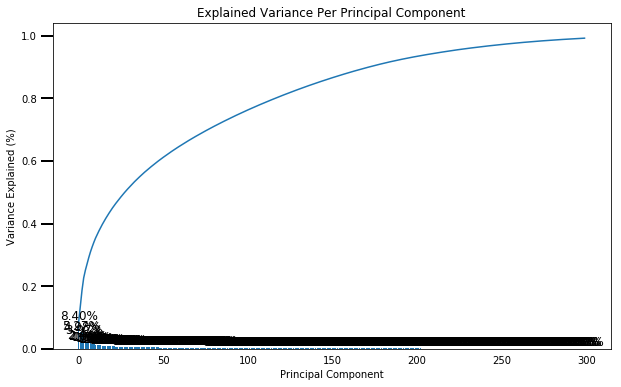

In [34]:
start_time = time.time()
pca300 = PCA(300)
# PCA calculated for only 100'000 values for computational time reasons
X_pca = pca300.fit_transform(azdias_scaled[0:10000])
scree_plot(pca300)
print("--- %s seconds ---" % (time.time() - start_time))

In [35]:
explained_variance = pd.DataFrame(pca300.explained_variance_ratio_.cumsum()*100)

In [36]:
print(explained_variance.iloc[0])
print(explained_variance.iloc[50])
print(explained_variance.iloc[100])
print(explained_variance.iloc[150])
print(explained_variance.iloc[200])
print(explained_variance.iloc[250])

0    8.409862
Name: 0, dtype: float64
0    61.123215
Name: 50, dtype: float64
0    76.253189
Name: 100, dtype: float64
0    86.552659
Name: 150, dtype: float64
0    93.377257
Name: 200, dtype: float64
0    97.159457
Name: 250, dtype: float64


In [37]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(100)
# In here not the entire dataset is fit, for computational time reasons. User is free to change it.
X_pca = pca.fit_transform(azdias_scaled[0:100000])
sum(pca.explained_variance_ratio_)

0.7484426959401479

### Discussion

The first dimension explains 8.4% of the variance, where as the 50 first ones explain 60. 
For the continuation of the analysis, 100 dimensions are selected, which explain 75% of the variance. Given the size of the dataset, I'll try not to have to many dimensions which lead to enormous computational time as well as potential overfitting

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population
Data was cleaned, transformed and scaled. Now, it's time to see how the data clusters in the principal components space. In this substep, k-means clustering is applied to the dataset and the average within-cluster distances from each point to their assigned cluster's centroid is used to decide on a number of clusters to keep.

In [38]:
# Over a number of different cluster counts...
ks = [1,2,3,5,8,12,15]
scores = []
for i in ks:
    print(i)
    
    #run k-means clustering on the data and...
    kmeans = KMeans(n_clusters=i)
    model = kmeans.fit(azdias_scaled[0:1000])

    # compute the average within-cluster distances
    scores.append(np.abs(model.score(azdias_scaled[0:1000])))

1
2
3
5
8
12
15


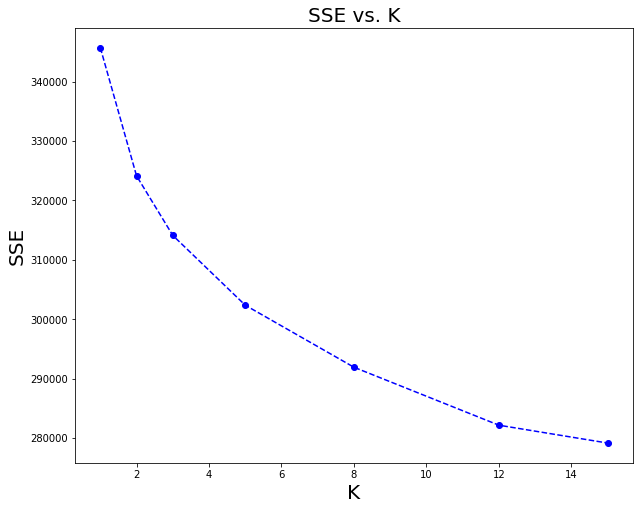

In [39]:
plt.figure(figsize=(10, 8)) 
plt.plot(ks,scores, linestyle='--', marker='o', color='b')
plt.xlabel('K', fontsize=20)
plt.ylabel('SSE', fontsize=20)
plt.title('SSE vs. K', fontsize=20)
plt.show()

In [40]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

# I've selected 6. Gradient is then much smaller.
kmeans = KMeans(n_clusters=6)
kmodel = kmeans.fit(X_pca)

### Discussion :
I've decided to keep 6 clusters because the gradient gets much smaller for higher k values.

### Step 3.2: Apply All Steps to the Customer Data

We can now repeat the same data preprocessing steps for the customer data, and make a prediction for the two datasets : the general population and the customers.

In [41]:
# Load in the customer demographics data, remove extra columns and clean it
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

customers.drop(columns=['CUSTOMER_GROUP', 'ONLINE_PURCHASE',
                    'PRODUCT_GROUP'], axis=1, inplace=True)

customers_clean = clean_data(customers, attributes)

customers_clean.head()

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Entering shape A : (191652, 366)
Starting replacing nan values
BIP_FLAG is surpisingly not found in df.
CAMEO_DEUINTL_2015 is surpisingly not found in df.
D19_KK_KUNDENTYP is surpisingly not found in df.
GEOSCORE_KLS7 is surpisingly not found in df.
HAUSHALTSSTRUKTUR is surpisingly not found in df.
KBA13_CCM_1400_2500 is surpisingly not found in df.
SOHO_FLAG is surpisingly not found in df.
WACHSTUMSGEBIET_NB is surpisingly not found in df.
New shape B : (191652, 350)
New shape C : (134245, 350)


/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/li

New shape D : (134245, 347)


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,MOVEMENT,DECADE,WEALTH,LIFE_STAGE
0,9626,2.0,1.0,10.0,1.0,0.0,0.0,2.0,1.0,0.0,...,6.0,9.0,7.0,3,1,4,0.0,2.0,1.0,3.0
2,143872,NaN,1.0,6.0,1.0,0.0,0.0,1.0,1.0,0.0,...,6.0,9.0,2.0,3,2,4,0.0,2.0,3.0,4.0
3,143873,1.0,1.0,8.0,0.0,NaN,0.0,0.0,1.0,0.0,...,NaN,9.0,7.0,1,1,4,1.0,1.0,2.0,4.0
4,143874,NaN,1.0,20.0,7.0,0.0,0.0,4.0,7.0,0.0,...,2.0,9.0,3.0,1,1,3,1.0,4.0,4.0,1.0
5,143888,1.0,1.0,11.0,1.0,0.0,0.0,2.0,1.0,0.0,...,6.0,9.0,1.0,2,1,3,0.0,2.0,3.0,4.0


In [42]:
customers_scaled = scaler.transform(imp.transform(customers_clean))

### Step 3.3: Compare Customer Data to Demographics Data

In [43]:
customers_cat = kmodel.predict(pca.transform(customers_scaled[0:100000]))
azdias_cat = kmodel.predict(pca.transform(azdias_scaled[0:100000]))

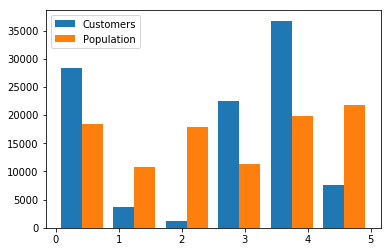

In [44]:
plt.hist([customers_cat,azdias_cat],bins=6)
plt.legend(['Customers','Population'])

### Discussion
Group 0, 1 and 5 seems tends to group people that are not customers, where as group 2,3,4 higher proportion of customers. Group 2 is a bit uncertain. Let's the top weighted features of each of them.

In [45]:
def sortFeaturesWeight(full_dataset, pca, i):
    # Dimension indexing
    dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = full_dataset.keys())
    components.index = dimensions
        
    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions
    
    # Return a dataframe with features weight for the dimension i of the pca
    return components.iloc[i].sort_values()

In [46]:
# Return top 5 correlated and top 5 anti correlated features of every k value. 
top_feat = []
for i in [0,1,2,4,5]:
    sorted_feat = sortFeaturesWeight(azdias_clean.iloc[0:100000], pca300,i)
    top_feat.extend(list(sorted_feat[0:7].index)+list(sorted_feat[0:7].index))

top_feat = list(set(top_feat))
print(len(top_feat))
print(top_feat)

33
['KBA13_KMH_180', 'KBA13_KW_0_60', 'KBA13_HALTER_25', 'KBA13_CCM_0_1400', 'ALTERSKATEGORIE_GROB', 'OST_WEST_KZ', 'PLZ8_BAUMAX', 'PLZ8_ANTG4', 'SEMIO_KRIT', 'KBA13_SEG_KOMPAKTKLASSE', 'SEMIO_KAEM', 'SEMIO_ERL', 'KBA13_ANTG4', 'KBA13_KMH_140_210', 'FINANZ_VORSORGER', 'SEMIO_DOM', 'KBA13_SITZE_5', 'CJT_TYP_6', 'SEMIO_RAT', 'KBA13_SEG_KLEINWAGEN', 'CJT_TYP_5', 'KBA13_BAUMAX', 'ANREDE_KZ', 'PLZ8_ANTG3', 'SHOPPER_TYP', 'CJT_TYP_4', 'KBA13_ANTG3', 'CAMEO_DEUG_2015', 'KBA13_SITZE_4', 'D19_GESAMT_ONLINE_DATUM', 'CJT_TYP_3', 'KBA13_KMH_140', 'KBA13_BJ_2000']


### Discussion
Now that I have found the 33 features that seem to be most correlated or anti-correlated to distinguish general population from customers, I would like to try these 33 features in a machine learning model. Random foreast seem to be particularly well adapted to establish rules (trees) amongst 33 variables.

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [47]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [48]:
mailout_train.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


Text(0,0.5,'Number of entries')

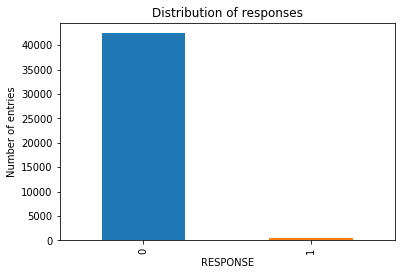

In [49]:
# Look at the distribution of the RESPONSE from customers
mailout_train['RESPONSE'].value_counts().plot(kind='bar')
plt.title('Distribution of responses')
plt.xlabel('RESPONSE')
plt.ylabel('Number of entries')

In [50]:
# Make the RESPONSE column the target
target_train = mailout_train['RESPONSE']
target_train.shape

(42962,)

In [51]:
# Drop RESPONSE columns for training
inputs_train = mailout_train.drop(columns=['RESPONSE'])

In [52]:
# Clean training data (last input as 0, means we do not want to remove rows with too many nan values)
inputs_train_clean = clean_data(inputs_train,attributes,0)
inputs_train_clean.shape

Entering shape A : (42962, 366)
Starting replacing nan values
BIP_FLAG is surpisingly not found in df.
CAMEO_DEUINTL_2015 is surpisingly not found in df.
D19_KK_KUNDENTYP is surpisingly not found in df.
GEOSCORE_KLS7 is surpisingly not found in df.
HAUSHALTSSTRUKTUR is surpisingly not found in df.
KBA13_CCM_1400_2500 is surpisingly not found in df.
SOHO_FLAG is surpisingly not found in df.
WACHSTUMSGEBIET_NB is surpisingly not found in df.
New shape D : (42962, 347)


(42962, 347)

In [53]:
# Index of the top features in the training dataset
idx_top_feat = []
for feat in top_feat:
    idx_top_feat.append(list(inputs_train_clean.columns).index(feat))

In [54]:
# Impute data for nan values. Scaling the data is not necessary for the RandomForest classifier.
inputs_train_clean = imp.transform(inputs_train_clean)
# Only columns of top features are kept for training
inputs_train_clean = inputs_train_clean[:,idx_top_feat]
inputs_train_clean.shape

(42962, 33)

In [55]:
# Divide the TRAIN set into training and validation to validate our model
X_train, X_valid, y_train, y_valid = train_test_split(
    inputs_train_clean, target_train, test_size=0.33, random_state=42)

In [56]:
model = RandomForestClassifier(random_state=42)

In [57]:
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [58]:
model.get_params

<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)>

In [59]:
pred_train = model.predict(X_train)
pred_valid = model.predict(X_valid)

In [60]:
# SCORES for train data : precision / recall / fscore / support
precision_recall_fscore_support(y_true=y_train, y_pred=pred_train)

(array([ 0.99544834,  1.        ]),
 array([ 1.        ,  0.63172805]),
 array([ 0.99771898,  0.77430556]),
 array([28431,   353]))

In [61]:
# SCORES for validation data : precision / recall / fscore / support
precision_recall_fscore_support(y_true=y_valid, y_pred=pred_valid)

(array([ 0.98737302,  0.        ]),
 array([ 0.99985713,  0.        ]),
 array([ 0.99357587,  0.        ]),
 array([13999,   179]))

In [62]:
# Use plot for the confusion matrix found on sklearn lib
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Normalized confusion matrix
[[ 1.          0.        ]
 [ 0.36827195  0.63172805]]
Confusion matrix, without normalization
[[13997     2]
 [  179     0]]


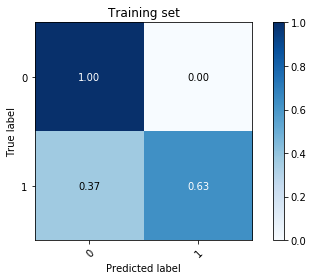

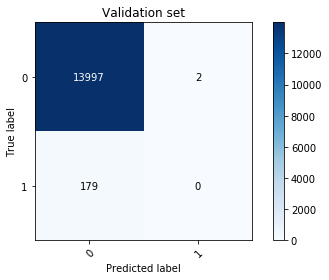

In [90]:
# Plot confusion matrix for training and validation sets
plot_confusion_matrix(y_pred=pred_train,y_true=y_train,classes=np.array([0,1]),normalize=True,title='Training set')
plot_confusion_matrix(y_pred=pred_valid,y_true=y_valid,classes=np.array([0,1]),title='Validation set')
plt.show()

### Discussion :
Obviously and as expected the RESPONSE is very much imbalanced, because most of people did not reply to the mail campaign.  Therefore an accuracy test would not fit this exercise. We looked at recall, f1 and support. The kaggle competition use the ROC score for instance.

We have plotted confusion matrices to understand the distribution of answers. Whereas sending e-mail and getting no response is okay, we want to have the True positive as high as possible, and avoid false negatives. In the latter case, it means we might have forgotten to send mails to people who would actually become members.

Results : the results for training seemed promising with quite many True positives captured. However, as soon as we used the validation data, this number went almost to zero. 

Let's try to optimize the hyperparameters.

### 4.1 Hyperparameters optimization

In [64]:
param_grid = {
    'max_features': [2],
    'min_samples_leaf': [3, 4],
    'n_estimators': [10,30]
}

In [65]:
rf = RandomForestClassifier(random_state=42)

In [66]:
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, verbose = 2)

In [67]:
X_train.shape, target_train.shape

((28784, 33), (42962,))

In [68]:
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] max_features=2, min_samples_leaf=3, n_estimators=10 .............
[CV]  max_features=2, min_samples_leaf=3, n_estimators=10, total=   0.2s
[CV] max_features=2, min_samples_leaf=3, n_estimators=10 .............
[CV]  max_features=2, min_samples_leaf=3, n_estimators=10, total=   0.2s
[CV] max_features=2, min_samples_leaf=3, n_estimators=10 .............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV]  max_features=2, min_samples_leaf=3, n_estimators=10, total=   0.2s
[CV] max_features=2, min_samples_leaf=3, n_estimators=30 .............
[CV]  max_features=2, min_samples_leaf=3, n_estimators=30, total=   0.5s
[CV] max_features=2, min_samples_leaf=3, n_estimators=30 .............
[CV]  max_features=2, min_samples_leaf=3, n_estimators=30, total=   0.5s
[CV] max_features=2, min_samples_leaf=3, n_estimators=30 .............
[CV]  max_features=2, min_samples_leaf=3, n_estimators=30, total=   0.5s
[CV] max_features=2, min_samples_leaf=4, n_estimators=10 .............
[CV]  max_features=2, min_samples_leaf=4, n_estimators=10, total=   0.2s
[CV] max_features=2, min_samples_leaf=4, n_estimators=10 .............
[CV]  max_features=2, min_samples_leaf=4, n_estimators=10, total=   0.2s
[CV] max_features=2, min_samples_leaf=4, n_estimators=10 .............
[CV]  max_features=2, min_samples_leaf=4, n_estimators=10, total=   0.2s
[CV] max_features=2, min_samples_leaf=4, n_estimators=30 ......

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    4.6s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_features': [2], 'min_samples_leaf': [3, 4], 'n_estimators': [10, 30]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [69]:
grid_search.best_params_

{'max_features': 2, 'min_samples_leaf': 3, 'n_estimators': 10}

In [70]:
pred_train_optim = grid_search.predict(X_train)
pred_valid_optim = grid_search.predict(X_valid)

In [71]:
# SCORES for train data (optimized with gridSearch) : precision / recall / fscore / support
precision_recall_fscore_support(y_true=y_train, y_pred=pred_train_optim)

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  fbeta_score : float (if average is not None) or array of float, shape =\


(array([ 0.98773624,  0.        ]),
 array([ 1.,  0.]),
 array([ 0.99383029,  0.        ]),
 array([28431,   353]))

In [72]:
# SCORES for validation data (optimized with gridSearch) : precision / recall / fscore / support
precision_recall_fscore_support(y_true=y_valid, y_pred=pred_valid_optim)

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  fbeta_score : float (if average is not None) or array of float, shape =\


(array([ 0.98737481,  0.        ]),
 array([ 1.,  0.]),
 array([ 0.9936473,  0.       ]),
 array([13999,   179]))

Normalized confusion matrix
[[ 1.  0.]
 [ 1.  0.]]


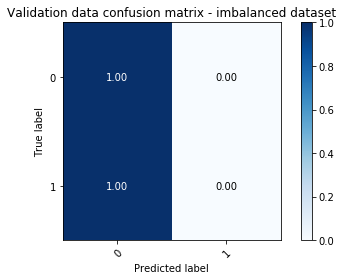

In [95]:
#plot_confusion_matrix(y_pred=pred_train_optim,y_true=y_train,classes=np.array([0,1]),normalize=True, title='Training set')
plot_confusion_matrix(y_pred=pred_valid_optim,y_true=y_valid,classes=np.array([0,1]),normalize=True, title='Validation data confusion matrix - imbalanced dataset')
plt.show()

### Discussion : 
hyperparemeters optimization did not work at all. In fact, most of the scoring metrics (apart from accuracy) got worse, and we highlighted before that accuracy was not an appropriate scoring method for this imbalanced data set.

In fact, the issue lies here in the training loss function. For RandomForestClassifiers, these are typically RMSE or MAE. But these will work best to increase accuracy.

While it seems difficult to have a more complex training loss function for our classifier, we could try to use over-sampling of the minority class to counter balance the problem.

### 4.2 Over-sampling the minority class

From library imblearn, which has severl techniques, we'll try RandomOverSampler

In [74]:
# Resample X_train and y_train so that they have the same length
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

In [75]:
X_resampled.shape, y_resampled.shape

((56862, 33), (56862,))

In [76]:
# Retrained a RandomForest Classifier with the balanced X and y
rf = RandomForestClassifier(random_state=42)
grid_search_ros = GridSearchCV(estimator = rf, param_grid = param_grid, verbose = 2)
grid_search_ros.fit(X_resampled, y_resampled)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] max_features=2, min_samples_leaf=3, n_estimators=10 .............
[CV]  max_features=2, min_samples_leaf=3, n_estimators=10, total=   0.6s
[CV] max_features=2, min_samples_leaf=3, n_estimators=10 .............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV]  max_features=2, min_samples_leaf=3, n_estimators=10, total=   0.4s
[CV] max_features=2, min_samples_leaf=3, n_estimators=10 .............
[CV]  max_features=2, min_samples_leaf=3, n_estimators=10, total=   0.4s
[CV] max_features=2, min_samples_leaf=3, n_estimators=30 .............
[CV]  max_features=2, min_samples_leaf=3, n_estimators=30, total=   1.3s
[CV] max_features=2, min_samples_leaf=3, n_estimators=30 .............
[CV]  max_features=2, min_samples_leaf=3, n_estimators=30, total=   1.2s
[CV] max_features=2, min_samples_leaf=3, n_estimators=30 .............
[CV]  max_features=2, min_samples_leaf=3, n_estimators=30, total=   1.2s
[CV] max_features=2, min_samples_leaf=4, n_estimators=10 .............
[CV]  max_features=2, min_samples_leaf=4, n_estimators=10, total=   0.4s
[CV] max_features=2, min_samples_leaf=4, n_estimators=10 .............
[CV]  max_features=2, min_samples_leaf=4, n_estimators=10, total=   0.4s
[CV] max_features=2, min_samples_leaf=4, n_estimators=10 ......

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:   11.5s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_features': [2], 'min_samples_leaf': [3, 4], 'n_estimators': [10, 30]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [77]:
pred_valid_ros = grid_search_ros.predict(X_valid)

In [78]:
# SCORES for validation data (optimized with gridSearch) : precision / recall / fscore / support
precision_recall_fscore_support(y_true=y_valid, y_pred=pred_valid_ros)

(array([ 0.98779357,  0.01701783]),
 array([ 0.91335095,  0.11731844]),
 array([ 0.9491148 ,  0.02972399]),
 array([13999,   179]))

Normalized confusion matrix
[[ 0.91335095  0.08664905]
 [ 0.88268156  0.11731844]]


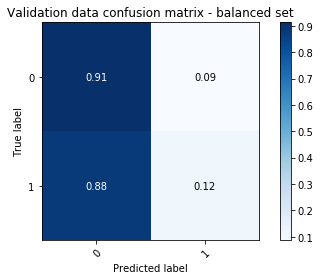

In [96]:
plot_confusion_matrix(y_pred=pred_valid_ros,y_true=y_valid,classes=np.array([0,1]),normalize=True,title='Validation data confusion matrix - balanced set')

### Conclusion

All metrics obtained for the second dimension (the 1) improved ! This is exactly what we wanted. It's a great sign that shows that over-sampling is a possible solution to be able to use RandomForest Classifier with imbalanced data. 

The scores are not yet very high, but it would be interesting to continue investigating hyperparameters optimization with the combined with the over-sampling method.

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [79]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [80]:
df_kaggle = pd.DataFrame()
df_kaggle['LNR'] = mailout_test['LNR']

In [81]:
# Clean test data (last input as 0, means we do not want to remove rows with too many nan values)
inputs_test_clean = clean_data(mailout_test,attributes,0)
inputs_test_clean.shape

Entering shape A : (42833, 366)
Starting replacing nan values
BIP_FLAG is surpisingly not found in df.
CAMEO_DEUINTL_2015 is surpisingly not found in df.
D19_KK_KUNDENTYP is surpisingly not found in df.
GEOSCORE_KLS7 is surpisingly not found in df.
HAUSHALTSSTRUKTUR is surpisingly not found in df.
KBA13_CCM_1400_2500 is surpisingly not found in df.
SOHO_FLAG is surpisingly not found in df.
WACHSTUMSGEBIET_NB is surpisingly not found in df.
New shape D : (42833, 347)


(42833, 347)

In [82]:
# Impute data for nan values. Scaling the data is not necessary for the RandomForest classifier.
inputs_test_clean = imp.transform(inputs_test_clean)
# Only columns of top features are kept for training
inputs_test_clean = inputs_test_clean[:,idx_top_feat]
inputs_test_clean.shape

(42833, 33)

In [83]:
df_kaggle['RESPONSE'] = grid_search_ros.predict(inputs_test_clean)

Text(0.5,1,'RESPONSE for kaggle competition')

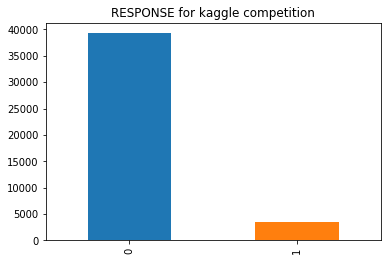

In [84]:
df_kaggle['RESPONSE'].value_counts().plot(kind='bar')
plt.title('RESPONSE for kaggle competition')

In [86]:
df_kaggle.to_csv('kaggle_competition.csv')